# Siamese model with numeric input

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from models.convolutive_siamese_model import ConvolutiveSiameseModel
from protein_dataset import ProteinDataset
from encoders.numeric_protein_encoder import NumericProteinEncoder
from utils import load_numpy_dataset
from pipelines import train_model, evaluate_model

# Config
device = torch.device("cuda")
batch_size = 128
num_epochs = 5
lr = 1e-3

max_length = 1024

vocab_size = (NumericProteinEncoder().vocabulary_size() + 1) # +1 for padding token

# Dataset
X1, X2, y = load_numpy_dataset(f"../processed_data/numeric_chunks_{max_length}")
dataset = ProteinDataset(X1, X2, y)
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

model = ConvolutiveSiameseModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256
)

model = train_model(\
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    model_save_path="../models/convolutive_siamese",
    lr=1e-3,
    epochs=50,
    patience=6
)


Epoch 1/50


Train loss: 0.4879


Val loss: 0.4352 | Accuracy: 0.8004
-- Best model saved.

Epoch 2/50


Train loss: 0.4337


Val loss: 0.4474 | Accuracy: 0.7926

Epoch 3/50


Train loss: 0.4149


Val loss: 0.4062 | Accuracy: 0.8156
-- Best model saved.

Epoch 4/50


Train loss: 0.4033


Val loss: 0.3984 | Accuracy: 0.8201
-- Best model saved.

Epoch 5/50


Train loss: 0.3936


Val loss: 0.3906 | Accuracy: 0.8246
-- Best model saved.

Epoch 6/50


Train loss: 0.3862


Val loss: 0.3974 | Accuracy: 0.8205

Epoch 7/50


Train loss: 0.3809


Val loss: 0.4034 | Accuracy: 0.8178

Epoch 8/50


Train loss: 0.3764


Val loss: 0.3819 | Accuracy: 0.8288
-- Best model saved.

Epoch 9/50


Train loss: 0.3726


Val loss: 0.3978 | Accuracy: 0.8189

Epoch 10/50


Train loss: 0.3696


Val loss: 0.3801 | Accuracy: 0.8305
-- Best model saved.

Epoch 11/50


Train loss: 0.3663


Val loss: 0.3832 | Accuracy: 0.8284

Epoch 12/50


Train loss: 0.3647


Val loss: 0.3664 | Accuracy: 0.8374
-- Best model saved.

Epoch 13/50


Train loss: 0.3617


Val loss: 0.3782 | Accuracy: 0.8307

Epoch 14/50


Train loss: 0.3604


Val loss: 0.3683 | Accuracy: 0.8376

Epoch 15/50


Train loss: 0.3581


Val loss: 0.3707 | Accuracy: 0.8357

Epoch 16/50


Train loss: 0.3570


Val loss: 0.3654 | Accuracy: 0.8391
-- Best model saved.

Epoch 17/50


Train loss: 0.3555


Val loss: 0.3764 | Accuracy: 0.8353

Epoch 18/50


Train loss: 0.3541


Val loss: 0.3611 | Accuracy: 0.8401
-- Best model saved.

Epoch 19/50


Train loss: 0.3530


Val loss: 0.3655 | Accuracy: 0.8384

Epoch 20/50


Train loss: 0.3520


Val loss: 0.3587 | Accuracy: 0.8408
-- Best model saved.

Epoch 21/50


Train loss: 0.3511


Val loss: 0.3610 | Accuracy: 0.8399

Epoch 22/50


Train loss: 0.3500


Val loss: 0.3683 | Accuracy: 0.8387

Epoch 23/50


Train loss: 0.3490


Val loss: 0.3575 | Accuracy: 0.8417
-- Best model saved.

Epoch 24/50


Train loss: 0.3482


Val loss: 0.3725 | Accuracy: 0.8344

Epoch 25/50


Train loss: 0.3470


Val loss: 0.3622 | Accuracy: 0.8368

Epoch 26/50


Train loss: 0.3466


Val loss: 0.3547 | Accuracy: 0.8432
-- Best model saved.

Epoch 27/50


Train loss: 0.3462


Val loss: 0.3873 | Accuracy: 0.8307

Epoch 28/50


Train loss: 0.3450


Val loss: 0.3525 | Accuracy: 0.8447
-- Best model saved.

Epoch 29/50


Train loss: 0.3444


Val loss: 0.3589 | Accuracy: 0.8402

Epoch 30/50


Train loss: 0.3436


Val loss: 0.3632 | Accuracy: 0.8397

Epoch 31/50


Train loss: 0.3431


Val loss: 0.3538 | Accuracy: 0.8442

Epoch 32/50


Train loss: 0.3424


Val loss: 0.3693 | Accuracy: 0.8362

Epoch 33/50


Train loss: 0.3418


Val loss: 0.3514 | Accuracy: 0.8448
-- Best model saved.

Epoch 34/50


Train loss: 0.3411


Val loss: 0.3519 | Accuracy: 0.8444

Epoch 35/50


Train loss: 0.3404


Val loss: 0.3494 | Accuracy: 0.8455
-- Best model saved.

Epoch 36/50


Train loss: 0.3401


Val loss: 0.3537 | Accuracy: 0.8449

Epoch 37/50


Train loss: 0.3401


Val loss: 0.3512 | Accuracy: 0.8444

Epoch 38/50


Train loss: 0.3392


Val loss: 0.3536 | Accuracy: 0.8434

Epoch 39/50


Train loss: 0.3387


Val loss: 0.3491 | Accuracy: 0.8459
-- Best model saved.

Epoch 40/50


Train loss: 0.3387


Val loss: 0.3620 | Accuracy: 0.8406

Epoch 41/50


Train loss: 0.3379


Val loss: 0.3487 | Accuracy: 0.8459
-- Best model saved.

Epoch 42/50


Train loss: 0.3378


Val loss: 0.3717 | Accuracy: 0.8363

Epoch 43/50


Train loss: 0.3373


Val loss: 0.3586 | Accuracy: 0.8415

Epoch 44/50


Train loss: 0.3371


Val loss: 0.3514 | Accuracy: 0.8463

Epoch 45/50


Train loss: 0.3365


Val loss: 0.3476 | Accuracy: 0.8465
-- Best model saved.

Epoch 46/50


Train loss: 0.3369


Val loss: 0.3517 | Accuracy: 0.8453

Epoch 47/50


Train loss: 0.3356


Val loss: 0.3880 | Accuracy: 0.8232

Epoch 48/50


Train loss: 0.3358


Val loss: 0.3522 | Accuracy: 0.8459

Epoch 49/50


Train loss: 0.3354


Val loss: 0.3531 | Accuracy: 0.8450

Epoch 50/50


Train loss: 0.3349


Val loss: 0.3674 | Accuracy: 0.8364


In [3]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        logits = model(x1, x2)
        preds = torch.sigmoid(logits) > 0.5
        correct += (preds == y.bool()).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8472


Test F1 Score : 0.8501
Test ROC AUC  : 0.9317



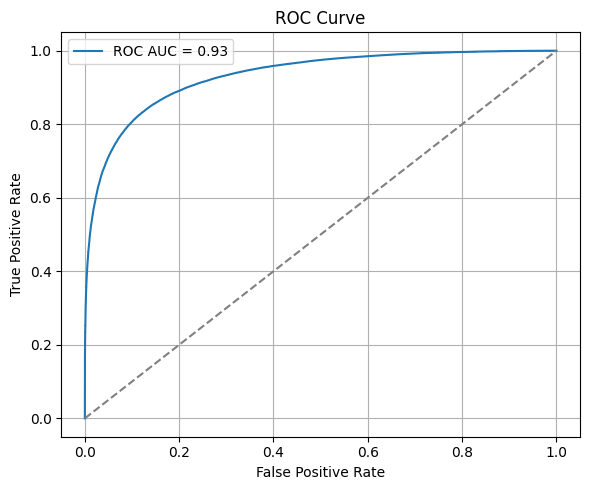

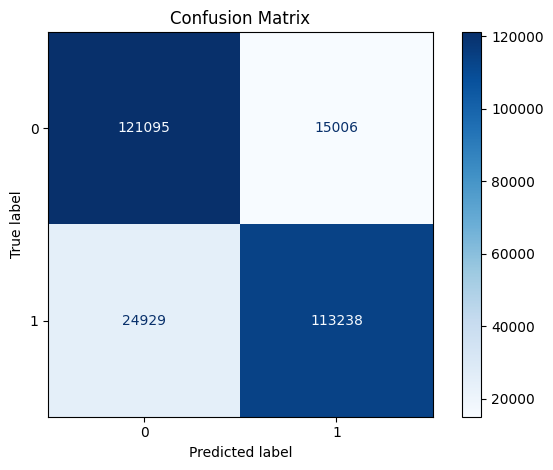

In [18]:
evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device
)